In [1]:
COUNT = 300
TRAIN = '/kaggle/input/american-sign-language-asl-hand-skeleton-dataset/dataset'

We want image embeddings for both EDA and classification, so let's add some code that will get us image embeddings using ResNeXt.

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 170MB/s]


Let's load up (a sample of) our data, including image embeddings and thumbnails. This is going to take a while, because we have so many classes.

In [3]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from PIL import Image

THUMBNAIL_SIZE = (64, 64)

def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGB').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_picture_from_glob(arg: str, tag: str,) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[tag, basename(input_file), embed(model=model, filename=input_file), png(filename=input_file)],
                        index=['tag', 'name', 'value', 'png'])
        for index, input_file in enumerate(list(iglob(pathname=arg))) if index < COUNT]
    print('encoded {} rows of {}  in {}'.format(len(result), tag, arrow.now() - time_get))
    return result

time_start = arrow.now()
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*')}
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in train_dict.items()]))
print('done in {}'.format(arrow.now() - time_start))

encoded 300 rows of N  in 0:00:45.200425
encoded 300 rows of R  in 0:00:44.029862
encoded 300 rows of B  in 0:00:44.301695
encoded 300 rows of I  in 0:00:44.087050
encoded 300 rows of F  in 0:00:44.069491
encoded 300 rows of H  in 0:00:44.394346
encoded 300 rows of E  in 0:00:44.395249
encoded 300 rows of U  in 0:00:43.656572
encoded 300 rows of M  in 0:00:43.807803
encoded 300 rows of X  in 0:00:44.542420
encoded 300 rows of K  in 0:00:43.769302
encoded 300 rows of Q  in 0:00:44.183346
encoded 300 rows of Y  in 0:00:44.284030
encoded 300 rows of S  in 0:00:45.458642
encoded 300 rows of G  in 0:00:44.748219
encoded 300 rows of A  in 0:00:45.555690
encoded 300 rows of O  in 0:00:45.435395
encoded 300 rows of T  in 0:00:44.256148
encoded 300 rows of V  in 0:00:45.058829
encoded 300 rows of Z  in 0:00:45.983080
encoded 300 rows of C  in 0:00:45.031877
encoded 300 rows of P  in 0:00:44.054999
encoded 300 rows of L  in 0:00:44.695289
encoded 300 rows of W  in 0:00:44.931685
encoded 300 rows

Next let's use TSNE to get x/y coordinates from our image embeddings.

In [4]:
from sklearn.manifold import TSNE

train_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
train_df[['x', 'y']] = train_reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 7800 samples in 0.047s...
[t-SNE] Computed neighbors for 7800 samples in 5.317s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7800
[t-SNE] Computed conditional probabilities for sample 2000 / 7800
[t-SNE] Computed conditional probabilities for sample 3000 / 7800
[t-SNE] Computed conditional probabilities for sample 4000 / 7800
[t-SNE] Computed conditional probabilities for sample 5000 / 7800
[t-SNE] Computed conditional probabilities for sample 6000 / 7800
[t-SNE] Computed conditional probabilities for sample 7000 / 7800
[t-SNE] Computed conditional probabilities for sample 7800 / 7800
[t-SNE] Mean sigma: 1.895099
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.746109
[t-SNE] KL divergence after 1000 iterations: 0.872336


Now we're ready to plot. 

In [5]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'tag', 'x', 'y']].sample(n=2000, random_state=2025))
factor_count = max(train_df['tag'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'tag', palette=palette, factors=train_df['tag'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: skeletons', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@tag</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=8, color=mapper)
show(plot_figure)

Loading BokehJS ...

What do we see? Our TSNE clusters are not just pretty tight in-cluster, but also for the most part our clusters are separated from each other. That's encourating, and we should expect that our model will have high accuracy. Let's build a model and see what we get.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df['value'].apply(pd.Series), train_df['tag'], test_size=0.25, random_state=2025, stratify=train_df['tag'])
logreg = LogisticRegression(max_iter=1000, tol=1e-12).fit(X_train, y_train)
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_test, y_pred=logreg.predict(X=X_test))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_test, y_pred=logreg.predict(X=X_test))))
print(classification_report(y_true=y_test, y_pred=logreg.predict(X=X_test)))

model fit in 661 iterations
accuracy: 0.9985
f1: 0.9985
              precision    recall  f1-score   support

           A       0.99      1.00      0.99        75
           B       1.00      1.00      1.00        75
           C       1.00      1.00      1.00        75
           D       1.00      1.00      1.00        75
           E       1.00      1.00      1.00        75
           F       1.00      1.00      1.00        75
           G       1.00      1.00      1.00        75
           H       1.00      1.00      1.00        75
           I       1.00      1.00      1.00        75
           J       1.00      1.00      1.00        75
           K       1.00      1.00      1.00        75
           L       1.00      1.00      1.00        75
           M       1.00      1.00      1.00        75
           N       1.00      0.99      0.99        75
           O       1.00      1.00      1.00        75
           P       1.00      1.00      1.00        75
           Q       1.00  

Almost all of our f1 scores are 1.0. Yay! Let's have a look at our model probabilities.

<Axes: xlabel='probability', ylabel='Count'>

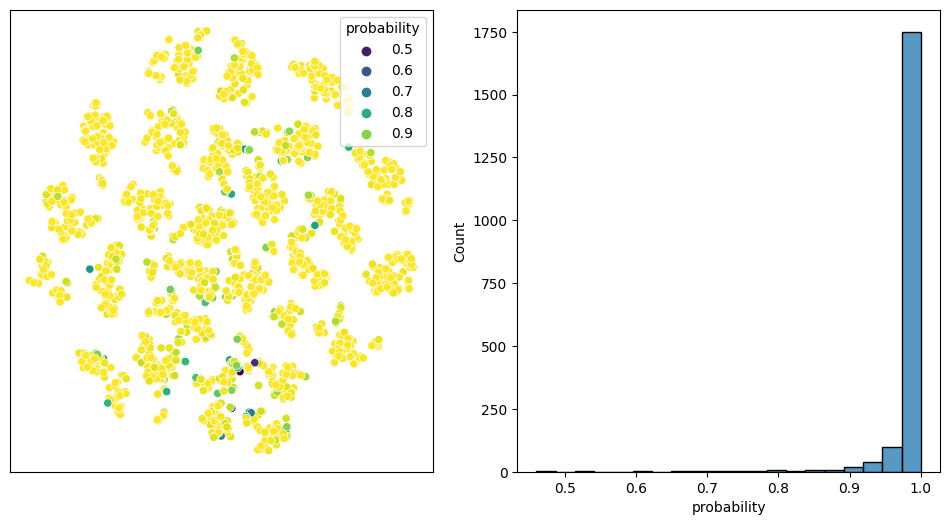

In [7]:
import matplotlib.pyplot as plt
import warnings
from seaborn import histplot
from seaborn import scatterplot

warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

plot_df = train_df.iloc[X_test.index][['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=X_test), axis=1)

plt, ax = plt.subplots(ncols=2, figsize=(12, 6))
scatterplot(ax=ax[0], data=plot_df, x='x', y='y', hue='probability', palette='viridis')
ax[0].set(xlabel=None) 
ax[0].set(ylabel=None)
ax[0].set(xticklabels=[])
ax[0].set(yticklabels=[])
ax[0].tick_params(axis='both', which='both', length=0)
histplot(ax=ax[1], data=plot_df, x='probability', bins=20)

Almost all of our model probabilities are high, and even when they're low the model predicts correctly. Such is the joy of very clean data.